In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings

from dataset import *
from eval import *
from torchvision import models


device = "cuda" if torch.cuda.is_available() else "cpu"

patch_paths_20x = glob.glob("data/train_03/level0/*.jpeg")
patch_paths_10x = glob.glob("data/train_03/level1/*.jpeg")
patch_paths_2_5x = glob.glob("data/train_03/level2/*.jpeg")

In [2]:
warnings.filterwarnings("ignore")

model = models.resnet34(pretrained=True).to(device)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()
pass

In [3]:
features_20x, coords_20x = extract_all_features(model, patch_paths_20x, device)
features_10x, coords_10x = extract_all_features(model, patch_paths_10x, device)
features_2_5x, coords_2_5x = extract_all_features(model, patch_paths_2_5x, device)

Extracting features: 100%|██████████| 4397/4397 [00:17<00:00, 248.24it/s]


In [4]:
labels_20x = cluster_features(features_20x)
labels_10x = cluster_features(features_10x)
labels_2_5x = cluster_features(features_2_5x)

In [5]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size=1000, num_classes=5):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
train_loader_20x = create_dataloader(features_20x, labels_20x, coords_20x)
train_loader_10x = create_dataloader(features_10x, labels_10x, coords_10x)
train_loader_2_5x = create_dataloader(features_2_5x, labels_2_5x, coords_2_5x)

In [7]:
model = MLPClassifier(input_size=features_20x.shape[1], num_classes=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader_20x, criterion, optimizer, num_epochs=70, device=device)

Epoch 1/70: 100%|██████████| 1982/1982 [00:01<00:00, 1230.36it/s]


Epoch 1/70 - Loss: 0.1457, Accuracy: 0.9401


Epoch 2/70: 100%|██████████| 1982/1982 [00:01<00:00, 1268.17it/s]


Epoch 2/70 - Loss: 0.1004, Accuracy: 0.9584


Epoch 3/70: 100%|██████████| 1982/1982 [00:01<00:00, 1301.52it/s]


Epoch 3/70 - Loss: 0.0861, Accuracy: 0.9643


Epoch 4/70: 100%|██████████| 1982/1982 [00:01<00:00, 1322.32it/s]


Epoch 4/70 - Loss: 0.0796, Accuracy: 0.9666


Epoch 5/70: 100%|██████████| 1982/1982 [00:01<00:00, 1289.21it/s]


Epoch 5/70 - Loss: 0.0723, Accuracy: 0.9698


Epoch 6/70: 100%|██████████| 1982/1982 [00:01<00:00, 1230.69it/s]


Epoch 6/70 - Loss: 0.0660, Accuracy: 0.9728


Epoch 7/70: 100%|██████████| 1982/1982 [00:01<00:00, 1319.91it/s]


Epoch 7/70 - Loss: 0.0640, Accuracy: 0.9733


Epoch 8/70: 100%|██████████| 1982/1982 [00:01<00:00, 1377.95it/s]


Epoch 8/70 - Loss: 0.0590, Accuracy: 0.9759


Epoch 9/70: 100%|██████████| 1982/1982 [00:01<00:00, 1370.22it/s]


Epoch 9/70 - Loss: 0.0551, Accuracy: 0.9772


Epoch 10/70: 100%|██████████| 1982/1982 [00:01<00:00, 1431.41it/s]


Epoch 10/70 - Loss: 0.0554, Accuracy: 0.9774


Epoch 11/70: 100%|██████████| 1982/1982 [00:01<00:00, 1329.36it/s]


Epoch 11/70 - Loss: 0.0511, Accuracy: 0.9792


Epoch 12/70: 100%|██████████| 1982/1982 [00:01<00:00, 1303.15it/s]


Epoch 12/70 - Loss: 0.0480, Accuracy: 0.9807


Epoch 13/70: 100%|██████████| 1982/1982 [00:01<00:00, 1413.86it/s]


Epoch 13/70 - Loss: 0.0482, Accuracy: 0.9803


Epoch 14/70: 100%|██████████| 1982/1982 [00:01<00:00, 1353.19it/s]


Epoch 14/70 - Loss: 0.0461, Accuracy: 0.9811


Epoch 15/70: 100%|██████████| 1982/1982 [00:01<00:00, 1373.72it/s]


Epoch 15/70 - Loss: 0.0434, Accuracy: 0.9824


Epoch 16/70: 100%|██████████| 1982/1982 [00:01<00:00, 1447.01it/s]


Epoch 16/70 - Loss: 0.0421, Accuracy: 0.9826


Epoch 17/70: 100%|██████████| 1982/1982 [00:01<00:00, 1394.40it/s]


Epoch 17/70 - Loss: 0.0410, Accuracy: 0.9832


Epoch 18/70: 100%|██████████| 1982/1982 [00:01<00:00, 1427.95it/s]


Epoch 18/70 - Loss: 0.0394, Accuracy: 0.9845


Epoch 19/70: 100%|██████████| 1982/1982 [00:01<00:00, 1167.51it/s]


Epoch 19/70 - Loss: 0.0405, Accuracy: 0.9839


Epoch 20/70: 100%|██████████| 1982/1982 [00:01<00:00, 1347.63it/s]


Epoch 20/70 - Loss: 0.0367, Accuracy: 0.9850


Epoch 21/70: 100%|██████████| 1982/1982 [00:01<00:00, 1355.50it/s]


Epoch 21/70 - Loss: 0.0367, Accuracy: 0.9853


Epoch 22/70: 100%|██████████| 1982/1982 [00:01<00:00, 1341.15it/s]


Epoch 22/70 - Loss: 0.0349, Accuracy: 0.9859


Epoch 23/70: 100%|██████████| 1982/1982 [00:01<00:00, 1368.19it/s]


Epoch 23/70 - Loss: 0.0329, Accuracy: 0.9866


Epoch 24/70: 100%|██████████| 1982/1982 [00:01<00:00, 1312.13it/s]


Epoch 24/70 - Loss: 0.0333, Accuracy: 0.9871


Epoch 25/70: 100%|██████████| 1982/1982 [00:01<00:00, 1282.55it/s]


Epoch 25/70 - Loss: 0.0303, Accuracy: 0.9883


Epoch 26/70: 100%|██████████| 1982/1982 [00:01<00:00, 1316.46it/s]


Epoch 26/70 - Loss: 0.0301, Accuracy: 0.9879


Epoch 27/70: 100%|██████████| 1982/1982 [00:01<00:00, 1291.80it/s]


Epoch 27/70 - Loss: 0.0298, Accuracy: 0.9885


Epoch 28/70: 100%|██████████| 1982/1982 [00:01<00:00, 1290.14it/s]


Epoch 28/70 - Loss: 0.0264, Accuracy: 0.9896


Epoch 29/70: 100%|██████████| 1982/1982 [00:01<00:00, 1326.90it/s]


Epoch 29/70 - Loss: 0.0294, Accuracy: 0.9886


Epoch 30/70: 100%|██████████| 1982/1982 [00:01<00:00, 1409.93it/s]


Epoch 30/70 - Loss: 0.0264, Accuracy: 0.9897


Epoch 31/70: 100%|██████████| 1982/1982 [00:01<00:00, 1380.11it/s]


Epoch 31/70 - Loss: 0.0249, Accuracy: 0.9906


Epoch 32/70: 100%|██████████| 1982/1982 [00:01<00:00, 1336.07it/s]


Epoch 32/70 - Loss: 0.0247, Accuracy: 0.9904


Epoch 33/70: 100%|██████████| 1982/1982 [00:01<00:00, 1193.08it/s]


Epoch 33/70 - Loss: 0.0243, Accuracy: 0.9907


Epoch 34/70: 100%|██████████| 1982/1982 [00:01<00:00, 1330.34it/s]


Epoch 34/70 - Loss: 0.0252, Accuracy: 0.9902


Epoch 35/70: 100%|██████████| 1982/1982 [00:01<00:00, 1286.49it/s]


Epoch 35/70 - Loss: 0.0242, Accuracy: 0.9908


Epoch 36/70: 100%|██████████| 1982/1982 [00:01<00:00, 1262.18it/s]


Epoch 36/70 - Loss: 0.0220, Accuracy: 0.9914


Epoch 37/70: 100%|██████████| 1982/1982 [00:01<00:00, 1307.77it/s]


Epoch 37/70 - Loss: 0.0210, Accuracy: 0.9922


Epoch 38/70: 100%|██████████| 1982/1982 [00:01<00:00, 1286.20it/s]


Epoch 38/70 - Loss: 0.0226, Accuracy: 0.9916


Epoch 39/70: 100%|██████████| 1982/1982 [00:01<00:00, 1272.41it/s]


Epoch 39/70 - Loss: 0.0200, Accuracy: 0.9924


Epoch 40/70: 100%|██████████| 1982/1982 [00:01<00:00, 1270.20it/s]


Epoch 40/70 - Loss: 0.0243, Accuracy: 0.9914


Epoch 41/70: 100%|██████████| 1982/1982 [00:01<00:00, 1199.33it/s]


Epoch 41/70 - Loss: 0.0176, Accuracy: 0.9931


Epoch 42/70: 100%|██████████| 1982/1982 [00:01<00:00, 1238.16it/s]


Epoch 42/70 - Loss: 0.0194, Accuracy: 0.9927


Epoch 43/70: 100%|██████████| 1982/1982 [00:01<00:00, 1275.66it/s]


Epoch 43/70 - Loss: 0.0199, Accuracy: 0.9927


Epoch 44/70: 100%|██████████| 1982/1982 [00:01<00:00, 1296.43it/s]


Epoch 44/70 - Loss: 0.0189, Accuracy: 0.9933


Epoch 45/70: 100%|██████████| 1982/1982 [00:01<00:00, 1222.76it/s]


Epoch 45/70 - Loss: 0.0174, Accuracy: 0.9937


Epoch 46/70: 100%|██████████| 1982/1982 [00:01<00:00, 1261.47it/s]


Epoch 46/70 - Loss: 0.0173, Accuracy: 0.9936


Epoch 47/70: 100%|██████████| 1982/1982 [00:01<00:00, 1319.00it/s]


Epoch 47/70 - Loss: 0.0158, Accuracy: 0.9941


Epoch 48/70: 100%|██████████| 1982/1982 [00:01<00:00, 1279.60it/s]


Epoch 48/70 - Loss: 0.0169, Accuracy: 0.9936


Epoch 49/70: 100%|██████████| 1982/1982 [00:01<00:00, 1230.68it/s]


Epoch 49/70 - Loss: 0.0167, Accuracy: 0.9939


Epoch 50/70: 100%|██████████| 1982/1982 [00:01<00:00, 1249.53it/s]


Epoch 50/70 - Loss: 0.0151, Accuracy: 0.9945


Epoch 51/70: 100%|██████████| 1982/1982 [00:01<00:00, 1298.60it/s]


Epoch 51/70 - Loss: 0.0167, Accuracy: 0.9941


Epoch 52/70: 100%|██████████| 1982/1982 [00:01<00:00, 1280.23it/s]


Epoch 52/70 - Loss: 0.0144, Accuracy: 0.9948


Epoch 53/70: 100%|██████████| 1982/1982 [00:01<00:00, 1187.30it/s]


Epoch 53/70 - Loss: 0.0170, Accuracy: 0.9941


Epoch 54/70: 100%|██████████| 1982/1982 [00:01<00:00, 1269.86it/s]


Epoch 54/70 - Loss: 0.0128, Accuracy: 0.9955


Epoch 55/70: 100%|██████████| 1982/1982 [00:01<00:00, 1297.39it/s]


Epoch 55/70 - Loss: 0.0140, Accuracy: 0.9951


Epoch 56/70: 100%|██████████| 1982/1982 [00:01<00:00, 1258.33it/s]


Epoch 56/70 - Loss: 0.0140, Accuracy: 0.9950


Epoch 57/70: 100%|██████████| 1982/1982 [00:01<00:00, 1275.04it/s]


Epoch 57/70 - Loss: 0.0143, Accuracy: 0.9949


Epoch 58/70: 100%|██████████| 1982/1982 [00:01<00:00, 1270.64it/s]


Epoch 58/70 - Loss: 0.0133, Accuracy: 0.9953


Epoch 59/70: 100%|██████████| 1982/1982 [00:01<00:00, 1288.49it/s]


Epoch 59/70 - Loss: 0.0129, Accuracy: 0.9954


Epoch 60/70: 100%|██████████| 1982/1982 [00:01<00:00, 1290.59it/s]


Epoch 60/70 - Loss: 0.0158, Accuracy: 0.9943


Epoch 61/70: 100%|██████████| 1982/1982 [00:01<00:00, 1297.81it/s]


Epoch 61/70 - Loss: 0.0140, Accuracy: 0.9950


Epoch 62/70: 100%|██████████| 1982/1982 [00:01<00:00, 1271.17it/s]


Epoch 62/70 - Loss: 0.0131, Accuracy: 0.9953


Epoch 63/70: 100%|██████████| 1982/1982 [00:01<00:00, 1304.32it/s]


Epoch 63/70 - Loss: 0.0135, Accuracy: 0.9960


Epoch 64/70: 100%|██████████| 1982/1982 [00:01<00:00, 1282.68it/s]


Epoch 64/70 - Loss: 0.0120, Accuracy: 0.9961


Epoch 65/70: 100%|██████████| 1982/1982 [00:01<00:00, 1257.66it/s]


Epoch 65/70 - Loss: 0.0138, Accuracy: 0.9954


Epoch 66/70: 100%|██████████| 1982/1982 [00:01<00:00, 1310.30it/s]


Epoch 66/70 - Loss: 0.0124, Accuracy: 0.9959


Epoch 67/70: 100%|██████████| 1982/1982 [00:01<00:00, 1326.67it/s]


Epoch 67/70 - Loss: 0.0130, Accuracy: 0.9954


Epoch 68/70: 100%|██████████| 1982/1982 [00:01<00:00, 1282.19it/s]


Epoch 68/70 - Loss: 0.0144, Accuracy: 0.9952


Epoch 69/70: 100%|██████████| 1982/1982 [00:01<00:00, 1321.48it/s]


Epoch 69/70 - Loss: 0.0092, Accuracy: 0.9966


Epoch 70/70: 100%|██████████| 1982/1982 [00:01<00:00, 1298.96it/s]

Epoch 70/70 - Loss: 0.0154, Accuracy: 0.9951
Training complete.


In [8]:
evaluate_model(model, train_loader_20x, device)

Evaluating: 100%|██████████| 1982/1982 [00:00<00:00, 3176.22it/s]

acc: 0.9985
F1: 0.9985
conf mtrx:
[[10309    13     0     4     1]
 [    6 15479     0     0     1]
 [    5     0 15711     0    10]
 [    1    47     0 11008     2]
 [    0     0     6     0 10815]]


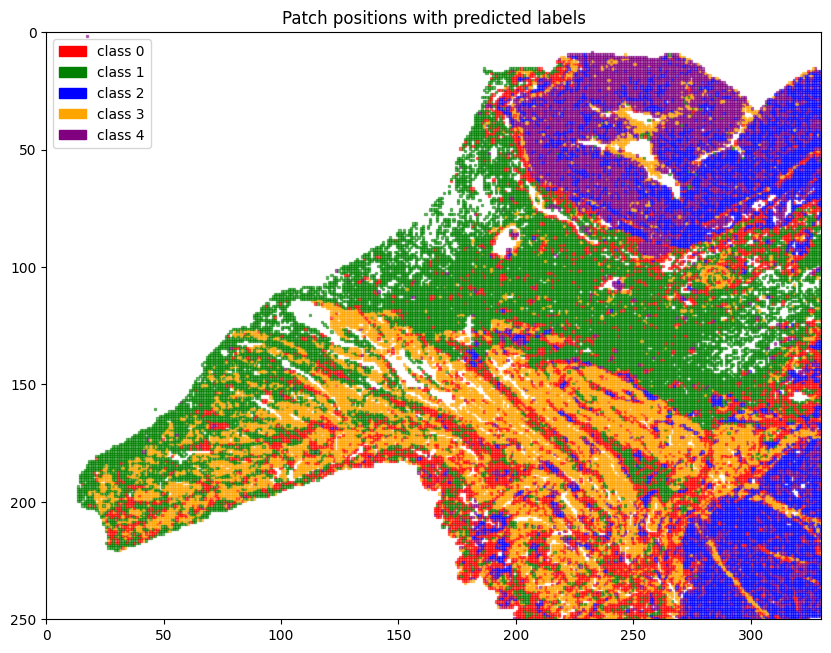

In [9]:
predicted_labels, patch_coords = get_predictions_and_coords_from_loader(model, train_loader_20x, device)
plot_patches_with_labels(patch_coords, predicted_labels)